## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D,Flatten,InputLayer,AveragePooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization,Dropout,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50,MobileNetV2
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score, recall_score
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet_v2 import preprocess_input
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Importing Data

In [ ]:
path = '/indian-food-images-dataset/Indian Food Images/Indian Food Images'

labels = os.listdir(path)
df = pd.DataFrame(columns=['img_path','label'])

for label in labels:
    img_dir_path = os.path.join(path,label)
    for img in os.listdir(img_dir_path):
        img_path = os.path.join(img_dir_path,img)
        df.loc[df.shape[0]] = [img_path,label]
        
# shuffling dataset
df = df.sample(frac=1).reset_index(drop=True)

In [40]:
print("Number of images",df.shape[0])
print("Number of labels",df['label'].nunique())

print('There are only 50 images per calss')

Number of images 4000
Number of labels 80
There are only 50 images per calss


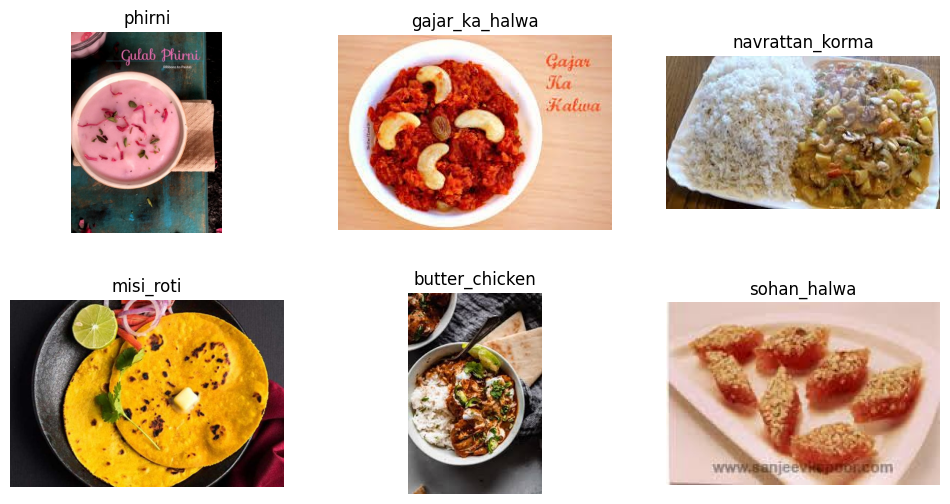

In [42]:
plt.figure(figsize=(12,6))

for i in range(1,3):
    for j in range(1,4):
        plt.subplot(2,3,3*(i-1) + j)
        img_data = cv2.imread(df['img_path'][3*(i-1) + (j-1)])
        image_rgb = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB) # BGR to RGB format
        plt.imshow(image_rgb)
        plt.title(df['label'][3*(i-1) + (j-1)])
        plt.axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

## Train, Test and Validation split

In [ ]:
# Splitting the dataset into training, testing and validation set

x_train, x_temp, y_train, y_temp = train_test_split(df['img_path'], df['label'], 
                                                    test_size=0.2, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


## Pre-Processing

In [4]:
def preprocess(img_paths):
    images = []
    for img_path in img_paths:
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image_rgb, (224, 224))
        image_normalized = image_resized.astype('float32') / 255
        images.append(image_normalized)
    return np.array(images)

In [55]:
datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]

)

# Create DataFrame for each dataset
train_df = pd.DataFrame({'img_path': x_train, 'label': y_train})
val_df = pd.DataFrame({'img_path': x_val, 'label': y_val})
test_df = pd.DataFrame({'img_path': x_test, 'label': y_test})

# Flow for training data
train_dataset = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=True,
    seed=42,
    subset=None  # No need to specify subset for training
)

# Flow for validation data
val_dataset = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=False,  # Validation data should not be shuffled
    seed=42,
    subset=None  # No need to specify subset for validation
)

# Flow for test data (you generally don't augment test data)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing

test_dataset = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=False,  # Test data should not be shuffled
    seed=42,
    subset=None  # No need to specify subset for test
)


Found 3200 validated image filenames belonging to 80 classes.
Found 400 validated image filenames belonging to 79 classes.
Found 400 validated image filenames belonging to 80 classes.


In [11]:
class_indices = train_dataset.class_indices

# Print the class indices dictionary
print("Class Indices:")
print(class_indices)

Class Indices:
{'adhirasam': 0, 'aloo_gobi': 1, 'aloo_matar': 2, 'aloo_methi': 3, 'aloo_shimla_mirch': 4, 'aloo_tikki': 5, 'anarsa': 6, 'ariselu': 7, 'bandar_laddu': 8, 'basundi': 9, 'bhatura': 10, 'bhindi_masala': 11, 'biryani': 12, 'boondi': 13, 'butter_chicken': 14, 'chak_hao_kheer': 15, 'cham_cham': 16, 'chana_masala': 17, 'chapati': 18, 'chhena_kheeri': 19, 'chicken_razala': 20, 'chicken_tikka': 21, 'chicken_tikka_masala': 22, 'chikki': 23, 'daal_baati_churma': 24, 'daal_puri': 25, 'dal_makhani': 26, 'dal_tadka': 27, 'dharwad_pedha': 28, 'doodhpak': 29, 'double_ka_meetha': 30, 'dum_aloo': 31, 'gajar_ka_halwa': 32, 'gavvalu': 33, 'ghevar': 34, 'gulab_jamun': 35, 'imarti': 36, 'jalebi': 37, 'kachori': 38, 'kadai_paneer': 39, 'kadhi_pakoda': 40, 'kajjikaya': 41, 'kakinada_khaja': 42, 'kalakand': 43, 'karela_bharta': 44, 'kofta': 45, 'kuzhi_paniyaram': 46, 'lassi': 47, 'ledikeni': 48, 'litti_chokha': 49, 'lyangcha': 50, 'maach_jhol': 51, 'makki_di_roti_sarson_da_saag': 52, 'malapua': 

In [12]:
index_to_class = {v: k for k, v in class_indices.items()}
print("Index to Class Mapping:")
print(index_to_class)

Index to Class Mapping:
{0: 'adhirasam', 1: 'aloo_gobi', 2: 'aloo_matar', 3: 'aloo_methi', 4: 'aloo_shimla_mirch', 5: 'aloo_tikki', 6: 'anarsa', 7: 'ariselu', 8: 'bandar_laddu', 9: 'basundi', 10: 'bhatura', 11: 'bhindi_masala', 12: 'biryani', 13: 'boondi', 14: 'butter_chicken', 15: 'chak_hao_kheer', 16: 'cham_cham', 17: 'chana_masala', 18: 'chapati', 19: 'chhena_kheeri', 20: 'chicken_razala', 21: 'chicken_tikka', 22: 'chicken_tikka_masala', 23: 'chikki', 24: 'daal_baati_churma', 25: 'daal_puri', 26: 'dal_makhani', 27: 'dal_tadka', 28: 'dharwad_pedha', 29: 'doodhpak', 30: 'double_ka_meetha', 31: 'dum_aloo', 32: 'gajar_ka_halwa', 33: 'gavvalu', 34: 'ghevar', 35: 'gulab_jamun', 36: 'imarti', 37: 'jalebi', 38: 'kachori', 39: 'kadai_paneer', 40: 'kadhi_pakoda', 41: 'kajjikaya', 42: 'kakinada_khaja', 43: 'kalakand', 44: 'karela_bharta', 45: 'kofta', 46: 'kuzhi_paniyaram', 47: 'lassi', 48: 'ledikeni', 49: 'litti_chokha', 50: 'lyangcha', 51: 'maach_jhol', 52: 'makki_di_roti_sarson_da_saag', 53

## Model Training

In [48]:
def build_model(base):
    base_model = base
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        
        Dense(256, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        
        Dense(80, activation='softmax'),  # For binary classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### MobileNetV2

In [56]:
mobilenet_model = build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_mobilenet = mobilenet_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=20
)

Epoch 1/20
100/100 [==============================] - 18s 133ms/step - loss: 3.9120 - accuracy: 0.1059
Epoch 2/20
100/100 [==============================] - 14s 136ms/step - loss: 2.5014 - accuracy: 0.4041
Epoch 3/20
100/100 [==============================] - 14s 143ms/step - loss: 1.6534 - accuracy: 0.6397
Epoch 4/20
100/100 [==============================] - 13s 134ms/step - loss: 1.0614 - accuracy: 0.7919
Epoch 5/20
100/100 [==============================] - 14s 140ms/step - loss: 0.6435 - accuracy: 0.8909
Epoch 6/20
100/100 [==============================] - 14s 138ms/step - loss: 0.4093 - accuracy: 0.9350
Epoch 7/20
100/100 [==============================] - 15s 143ms/step - loss: 0.3011 - accuracy: 0.9531
Epoch 8/20
100/100 [==============================] - 14s 141ms/step - loss: 0.2182 - accuracy: 0.9700
Epoch 9/20
100/100 [==============================] - 15s 147ms/step - loss: 0.1837 - accuracy: 0.9719
Epoch 10/20
100/100 [==============================] - 15s 147ms/step - l

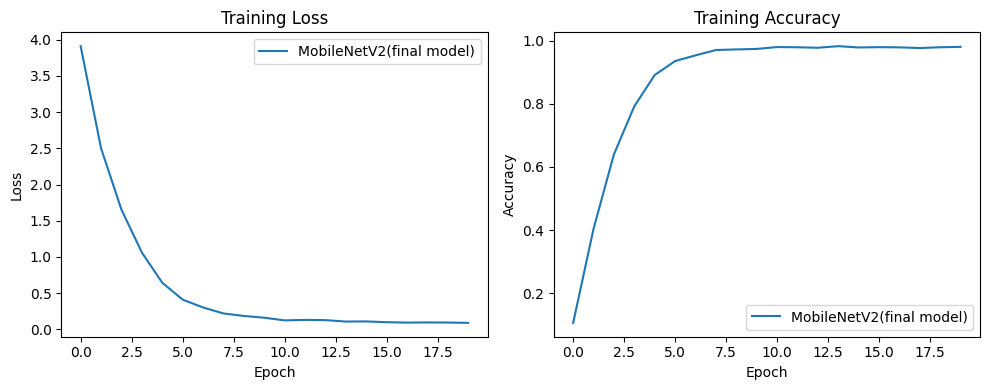

In [57]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2(final model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2(final model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [60]:
# finding y_pred using x_val
y_pred = []
for img_path in x_val:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = mobilenet_model.predict(img_array,verbose=False)
    predicted_class_index = np.argmax(predictions)
    y_pred.append(index_to_class[predicted_class_index])
    

In [61]:
print(f"validation accuracy : {accuracy_score(y_val,y_pred)}")

validation accuracy : 0.465


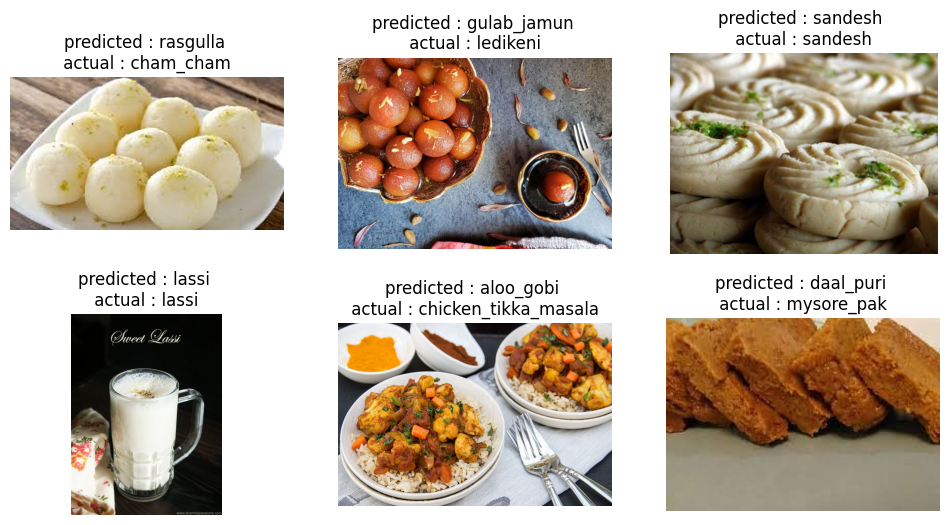

In [62]:
plt.figure(figsize=(12,6))

for i in range(1,3):
    for j in range(1,4):
        plt.subplot(2,3,3*(i-1) + j)
        image = cv2.imread(x_val.values[3*(i-1) + (j-1)])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB format
        plt.imshow(image_rgb)
        plt.title(f"predicted : {y_pred[3*(i-1) + (j-1)]} \n actual : {y_val.values[3*(i-1) + (j-1)]} ")
        plt.axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

In [63]:
print(classification_report(y_val,y_pred))

                              precision    recall  f1-score   support

                   adhirasam       0.17      0.33      0.22         3
                   aloo_gobi       0.33      0.60      0.43         5
                  aloo_matar       0.00      0.00      0.00         6
                  aloo_methi       0.46      1.00      0.63         6
           aloo_shimla_mirch       1.00      0.33      0.50         3
                  aloo_tikki       0.33      0.75      0.46         4
                      anarsa       0.33      0.29      0.31         7
                     ariselu       0.44      0.57      0.50         7
                bandar_laddu       0.75      0.75      0.75         4
                     basundi       0.20      0.17      0.18         6
                     bhatura       0.83      0.91      0.87        11
               bhindi_masala       0.40      0.67      0.50         3
                     biryani       1.00      0.56      0.71         9
                   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

### VGG16

In [64]:
from keras.applications.vgg16 import VGG16

vgg16 = build_model(VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False))

history_vgg = vgg16.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=20
)

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/20
100/100 [==============================] - 21s 160ms/step - loss: 4.4966 - accuracy: 0.0406
Epoch 2/20
100/100 [==============================] - 14s 143ms/step - loss: 3.5359 - accuracy: 0.1606
Epoch 3/20
100/100 [==============================] - 15s 145ms/step - loss: 2.9874 - accuracy: 0.2853
Epoch 4/20
100/100 [==============================] - 15s 149ms/step - loss: 2.4854 - accuracy: 0.3991
Epoch 5/20
100/100 [==============================] - 15s 144ms/step - loss: 2.1551 - accuracy: 0.4697
Epoch 6/20
100/100 [==============================] - 15s 146ms/step - loss: 1.9257 - accuracy: 0.5031
Epoch 7/20
100/100 [==============================] - 14s 144ms/step - loss: 1.5780 - accuracy: 0.5975
Epoch 8/20
100/100 [==============================] - 15s 154ms/step - loss: 1.2990 - accuracy: 0.6844
Epoch 9/20
100/100 [==============================] - 14s 141ms/step - loss: 1.0812 - accuracy: 0.7250
Epoch 10

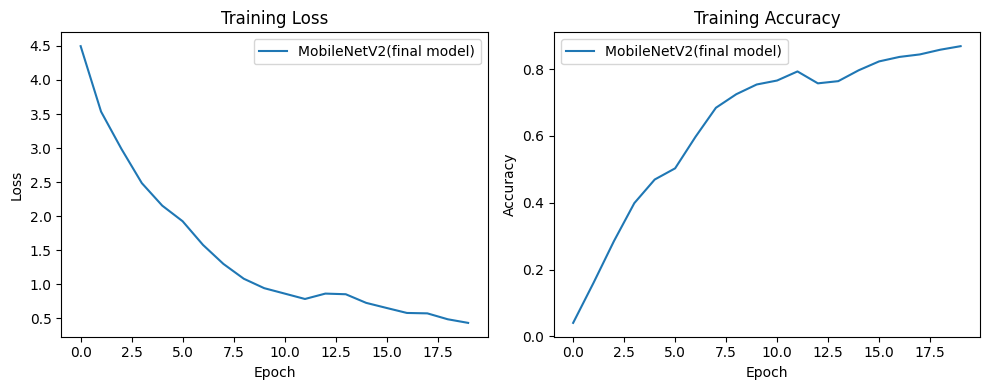

In [66]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['loss'], label='MobileNetV2(final model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['accuracy'], label='MobileNetV2(final model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [69]:
from tensorflow.keras.preprocessing import image


# finding y_pred using x_val
y_pred = []
for img_path in x_val:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = vgg16.predict(img_array,verbose=False)
    predicted_class_index = np.argmax(predictions)
    y_pred.append(index_to_class[predicted_class_index])

print(f"validation accuracy : {accuracy_score(y_val,y_pred)}")

validation accuracy : 0.01


In [70]:
print(classification_report(y_val,y_pred))

                              precision    recall  f1-score   support

                   adhirasam       0.00      0.00      0.00         3
                   aloo_gobi       0.00      0.00      0.00         5
                  aloo_matar       0.00      0.00      0.00         6
                  aloo_methi       0.00      0.00      0.00         6
           aloo_shimla_mirch       0.00      0.00      0.00         3
                  aloo_tikki       0.00      0.00      0.00         4
                      anarsa       0.00      0.00      0.00         7
                     ariselu       0.00      0.00      0.00         7
                bandar_laddu       0.00      0.00      0.00         4
                     basundi       0.00      0.00      0.00         6
                     bhatura       0.00      0.00      0.00        11
               bhindi_masala       0.00      0.00      0.00         3
                     biryani       0.00      0.00      0.00         9
                   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### InceptionV3

In [71]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inc_model = build_model(InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet'))
history_inc = inc_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=20,
)

87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/20
100/100 [==============================] - 22s 140ms/step - loss: 4.2469 - accuracy: 0.0675
Epoch 2/20
100/100 [==============================] - 14s 139ms/step - loss: 3.1766 - accuracy: 0.2244
Epoch 3/20
100/100 [==============================] - 14s 137ms/step - loss: 2.5813 - accuracy: 0.3622
Epoch 4/20
100/100 [==============================] - 14s 141ms/step - loss: 2.1517 - accuracy: 0.4666
Epoch 5/20
100/100 [==============================] - 14s 141ms/step - loss: 1.8430 - accuracy: 0.5231
Epoch 6/20
100/100 [==============================] - 14s 142ms/step - loss: 1.5994 - accuracy: 0.5913
Epoch 7/20
100/100 [==============================] - 14s 138ms/step - loss: 1.3797 - accuracy: 0.6444
Epoch 8/20
100/100 [==============================] - 15s 145ms/step - loss: 1.1475 - accuracy: 0.6944
Epoch 9/20
100/100 [==============================] - 15s 145ms/step - loss: 1.0112 - accuracy: 0.7362
Epoch 10

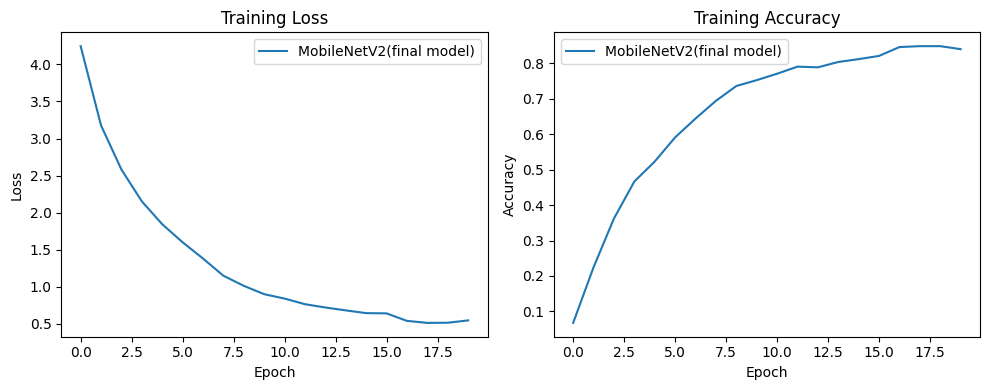

In [75]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_inc.history['loss'], label='MobileNetV2(final model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_inc.history['accuracy'], label='MobileNetV2(final model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [76]:
from tensorflow.keras.preprocessing import image


# finding y_pred using x_val
y_pred = []
for img_path in x_val:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = inc_model.predict(img_array,verbose=False)
    predicted_class_index = np.argmax(predictions)
    y_pred.append(index_to_class[predicted_class_index])


In [78]:
print(f"validation accuracy : {accuracy_score(y_val,y_pred)}")

validation accuracy : 0.4075


In [79]:
print(classification_report(y_val,y_pred))

                              precision    recall  f1-score   support

                   adhirasam       0.08      0.33      0.13         3
                   aloo_gobi       0.23      0.60      0.33         5
                  aloo_matar       0.67      0.33      0.44         6
                  aloo_methi       0.50      0.33      0.40         6
           aloo_shimla_mirch       0.00      0.00      0.00         3
                  aloo_tikki       0.20      0.25      0.22         4
                      anarsa       0.40      0.29      0.33         7
                     ariselu       0.25      0.14      0.18         7
                bandar_laddu       0.75      0.75      0.75         4
                     basundi       0.50      0.33      0.40         6
                     bhatura       0.71      0.91      0.80        11
               bhindi_masala       0.50      0.33      0.40         3
                     biryani       0.86      0.67      0.75         9
                   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

## Combined Graph

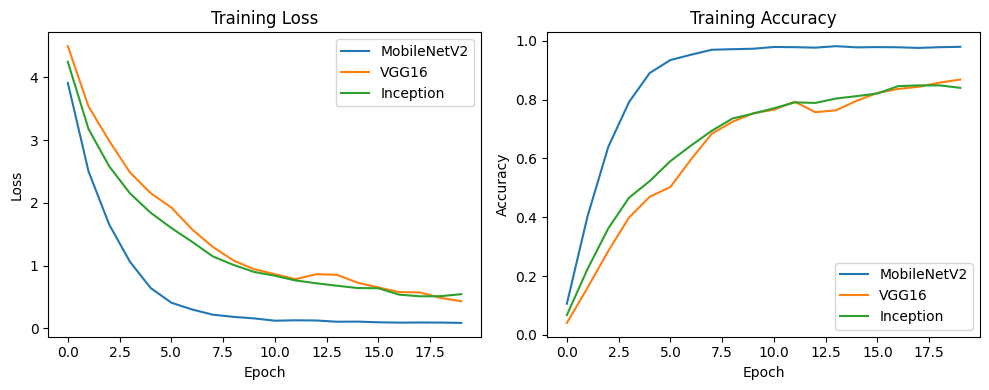

In [80]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2')
plt.plot(history_vgg.history['loss'], label='VGG16')
plt.plot(history_inc.history['loss'], label='Inception')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2')
plt.plot(history_vgg.history['accuracy'], label='VGG16')
plt.plot(history_inc.history['accuracy'], label='Inception')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Optimisation

In [5]:
#Applying Additional Data Augmentation techniques

datagen = ImageDataGenerator(
    rescale=1./255,    
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'

)

# Create DataFrame for each dataset
train_df = pd.DataFrame({'img_path': x_train, 'label': y_train})
val_df = pd.DataFrame({'img_path': x_val, 'label': y_val})
test_df = pd.DataFrame({'img_path': x_test, 'label': y_test})

# Flow for training data
train_dataset = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=True,
    seed=42,
    subset=None  # No need to specify subset for training
)

# Flow for validation data
val_dataset = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=False,  # Validation data should not be shuffled
    seed=42,
    subset=None  # No need to specify subset for validation
)

# Flow for test data (you generally don't augment test data)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing

test_dataset = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=False,  # Test data should not be shuffled
    seed=42,
    subset=None  # No need to specify subset for test
)


Found 3200 validated image filenames belonging to 80 classes.
Found 400 validated image filenames belonging to 80 classes.
Found 400 validated image filenames belonging to 79 classes.


In [15]:
def final_build_model(base_model):
    base_model.trainable = False  

    model = Sequential([
        base_model,
        Flatten(),  
        
        Dense(256, activation='relu'),
        Dropout(0.3),  
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        
        Dense(80, activation='softmax'), 
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [16]:
final_model = final_build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_final = final_model.fit(
    train_dataset,
    steps_per_epoch=100,
    epochs=100,
)

Epoch 1/100
100/100 [==============================] - 54s 493ms/step - loss: 4.1540 - accuracy: 0.0759
Epoch 2/100
100/100 [==============================] - 50s 503ms/step - loss: 3.1602 - accuracy: 0.2241
Epoch 3/100
100/100 [==============================] - 50s 498ms/step - loss: 2.6994 - accuracy: 0.3231
Epoch 4/100
100/100 [==============================] - 51s 506ms/step - loss: 2.4233 - accuracy: 0.3744
Epoch 5/100
100/100 [==============================] - 51s 512ms/step - loss: 2.1375 - accuracy: 0.4484
Epoch 6/100
100/100 [==============================] - 51s 508ms/step - loss: 1.9455 - accuracy: 0.4794
Epoch 7/100
100/100 [==============================] - 51s 512ms/step - loss: 1.7930 - accuracy: 0.5194
Epoch 8/100
100/100 [==============================] - 52s 517ms/step - loss: 1.6817 - accuracy: 0.5419
Epoch 9/100
100/100 [==============================] - 51s 507ms/step - loss: 1.5355 - accuracy: 0.5813
Epoch 10/100
100/100 [==============================] - 50s 503m

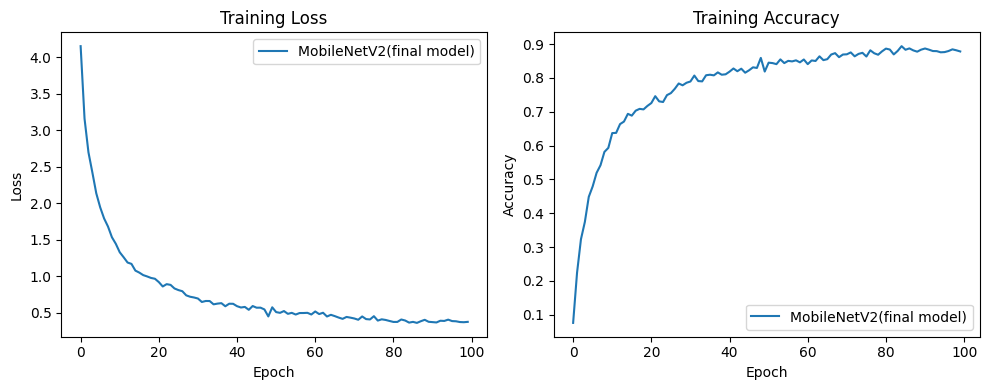

In [17]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_final.history['loss'], label='MobileNetV2(final model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_final.history['accuracy'], label='MobileNetV2(final model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Validation and Accuracy

In [18]:
# finding y_pred using x_val
y_pred = []
for img_path in x_val:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = final_model.predict(img_array,verbose=False)
    predicted_class_index = np.argmax(predictions)
    y_pred.append(index_to_class[predicted_class_index])
    

In [19]:
print(f"validation accuracy : {accuracy_score(y_val,y_pred)}")

validation accuracy : 0.5125


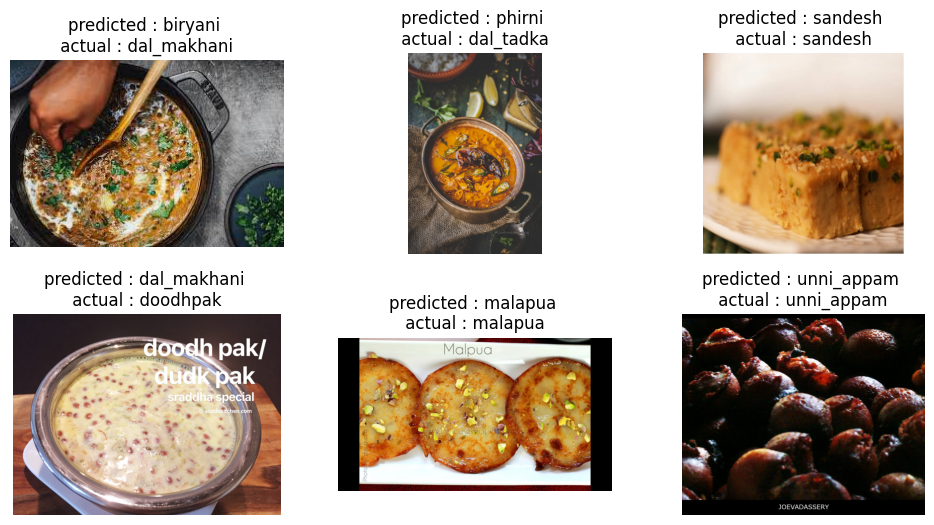

In [20]:
plt.figure(figsize=(12,6))

for i in range(1,3):
    for j in range(1,4):
        plt.subplot(2,3,3*(i-1) + j)
        image = cv2.imread(x_val.values[3*(i-1) + (j-1)])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB format
        plt.imshow(image_rgb)
        plt.title(f"predicted : {y_pred[3*(i-1) + (j-1)]} \n actual : {y_val.values[3*(i-1) + (j-1)]} ")
        plt.axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

## Confusion matrix

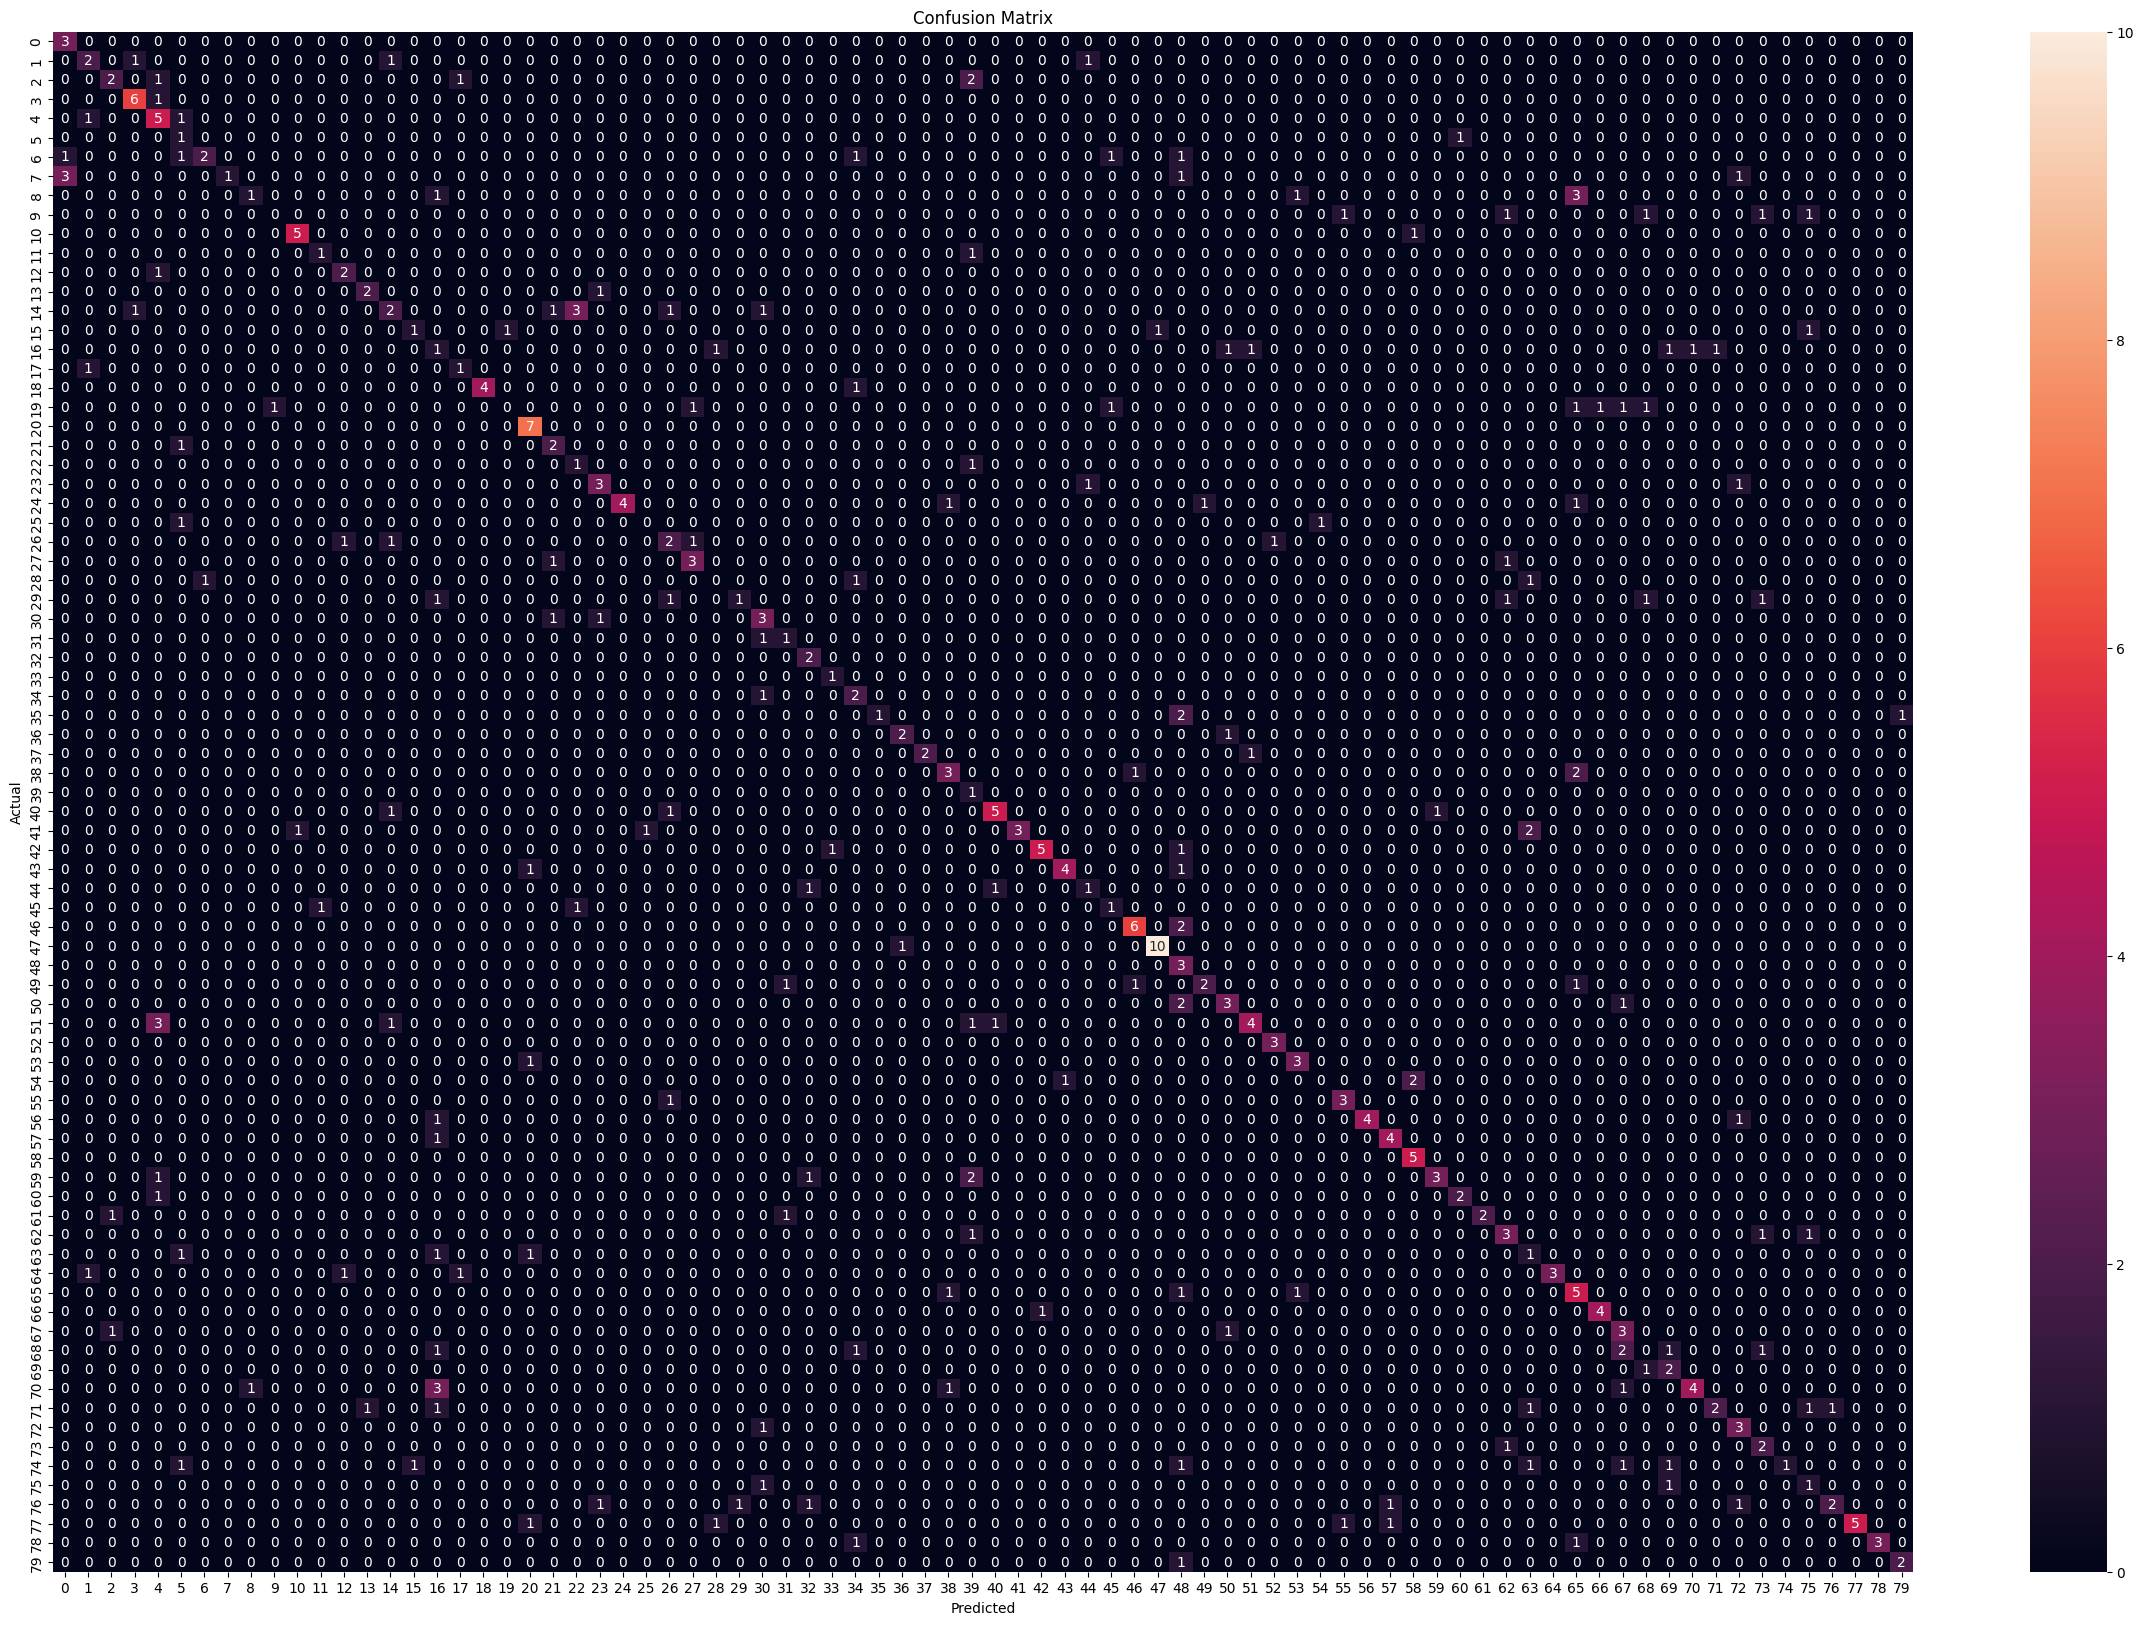

In [21]:
plt.figure(figsize=(30,20))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Classification report

In [22]:
print(classification_report(y_val,y_pred))

                              precision    recall  f1-score   support

                   adhirasam       0.43      1.00      0.60         3
                   aloo_gobi       0.40      0.40      0.40         5
                  aloo_matar       0.50      0.33      0.40         6
                  aloo_methi       0.75      0.86      0.80         7
           aloo_shimla_mirch       0.38      0.71      0.50         7
                  aloo_tikki       0.14      0.50      0.22         2
                      anarsa       0.67      0.29      0.40         7
                     ariselu       1.00      0.17      0.29         6
                bandar_laddu       0.50      0.17      0.25         6
                     basundi       0.00      0.00      0.00         5
                     bhatura       0.83      0.83      0.83         6
               bhindi_masala       0.50      0.50      0.50         2
                     biryani       0.50      0.67      0.57         3
                   